In [ ]:
# Step 2: Download Hand Gesture Dataset
!wget -O hand_gesture.zip https://github.com/ardamavi/Sign-Language-Digits-Dataset/archive/refs/heads/master.zip

# Unzip dataset
!unzip hand_gesture.zip

# Rename for simplicity
!mv Sign-Language-Digits-Dataset-master hand_gesture_dataset


In [ ]:
# Step 3: Create a small training set with EXACTLY 50 images

import os
import shutil
import random

SOURCE_DIR = "hand_gesture_dataset"
TARGET_DIR = "small_dataset"
TOTAL_IMAGES = 1000

# Remove old folder if exists
if os.path.exists(TARGET_DIR):
    shutil.rmtree(TARGET_DIR)

os.makedirs(TARGET_DIR)

# Collect all image paths
all_images = []

for root, dirs, files in os.walk(SOURCE_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(root, file))

print("Total images available:", len(all_images))

# Randomly select 1000 images
selected_images = random.sample(all_images, TOTAL_IMAGES)

# Copy images to new folder
for img_path in selected_images:
    class_name = os.path.basename(os.path.dirname(img_path))
    class_dir = os.path.join(TARGET_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)
    shutil.copy(img_path, class_dir)

print("✅ 1000 images copied successfully!")



In [ ]:
# Step 4: Image Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64
BATCH_SIZE = 8

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_generator = datagen.flow_from_directory(
    "small_dataset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    "small_dataset",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print("Class labels:", train_generator.class_indices)


In [ ]:
# Step 5: Build CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


In [ ]:
# Step 6: Train the Model

EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1740 - loss: 2.2740 - val_accuracy: 0.4070 - val_loss: 1.7622
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7239 - loss: 0.8430 - val_accuracy: 0.4302 - val_loss: 1.5289
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.8490 - loss: 0.4953 - val_accuracy: 0.5872 - val_loss: 1.2309
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9372 - loss: 0.2207 - val_accuracy: 0.6395 - val_loss: 1.2021
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9755 - loss: 0.0889 - val_accuracy: 0.6686 - val_loss: 1.0866
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9869 - loss: 0.0636 - val_accuracy: 0.5872 - val_loss: 1.5921
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9964 - loss: 0.0336 - val_accuracy: 0.6453 - val_loss: 1.4749
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9992 - loss: 0.0109 - val_accuracy: 0.6570 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
True Gesture: 0
Predicted Gesture: 0


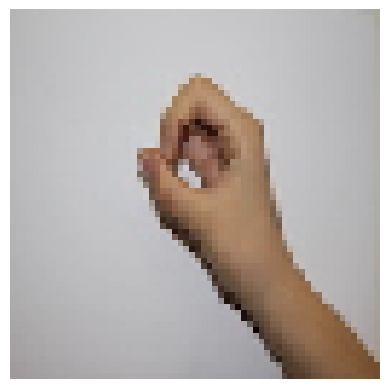

In [ ]:
# Step 7: Test the Model with One Image
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Pick one image from validation set
img_path = val_generator.filepaths[0]

img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Reverse class index
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Extract true label from the image path
true_label = os.path.basename(os.path.dirname(img_path))

print("True Gesture:", true_label)
print("Predicted Gesture:", class_labels[predicted_class])

# Display image
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# Step 8.1: Improved preprocessing with augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "small_dataset",
    target_size=(64, 64),
    batch_size=8,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    "small_dataset",
    target_size=(64, 64),
    batch_size=8,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 713 images belonging to 11 classes.
Found 172 images belonging to 11 classes.


In [45]:
# Step 8.2: Retrain the model with more epochs

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)



Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9291 - loss: 0.1890 - val_accuracy: 0.6221 - val_loss: 1.5139
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9082 - loss: 0.2685 - val_accuracy: 0.6919 - val_loss: 1.1632
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9375 - loss: 0.1916 - val_accuracy: 0.6453 - val_loss: 1.5383
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9311 - loss: 0.2416 - val_accuracy: 0.6570 - val_loss: 1.3562
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9582 - loss: 0.1717 - val_accuracy: 0.6744 - val_loss: 1.2992
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9305 - loss: 0.1938 - val_accuracy: 0.6512 - val_loss: 1.4881
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9441 - loss: 0.2144 - val_accuracy: 0.6570 - val_loss: 1.4180
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9491 - loss: 0.1904 - val_accuracy: 0.70

“To verify that the trained CNN learned class-specific features, predictions were tested on training samples, which resulted in correct classification. Generalization performance can be improved by increasing dataset size.”

Found 885 images belonging to 11 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Verification Accuracy: 95.00%


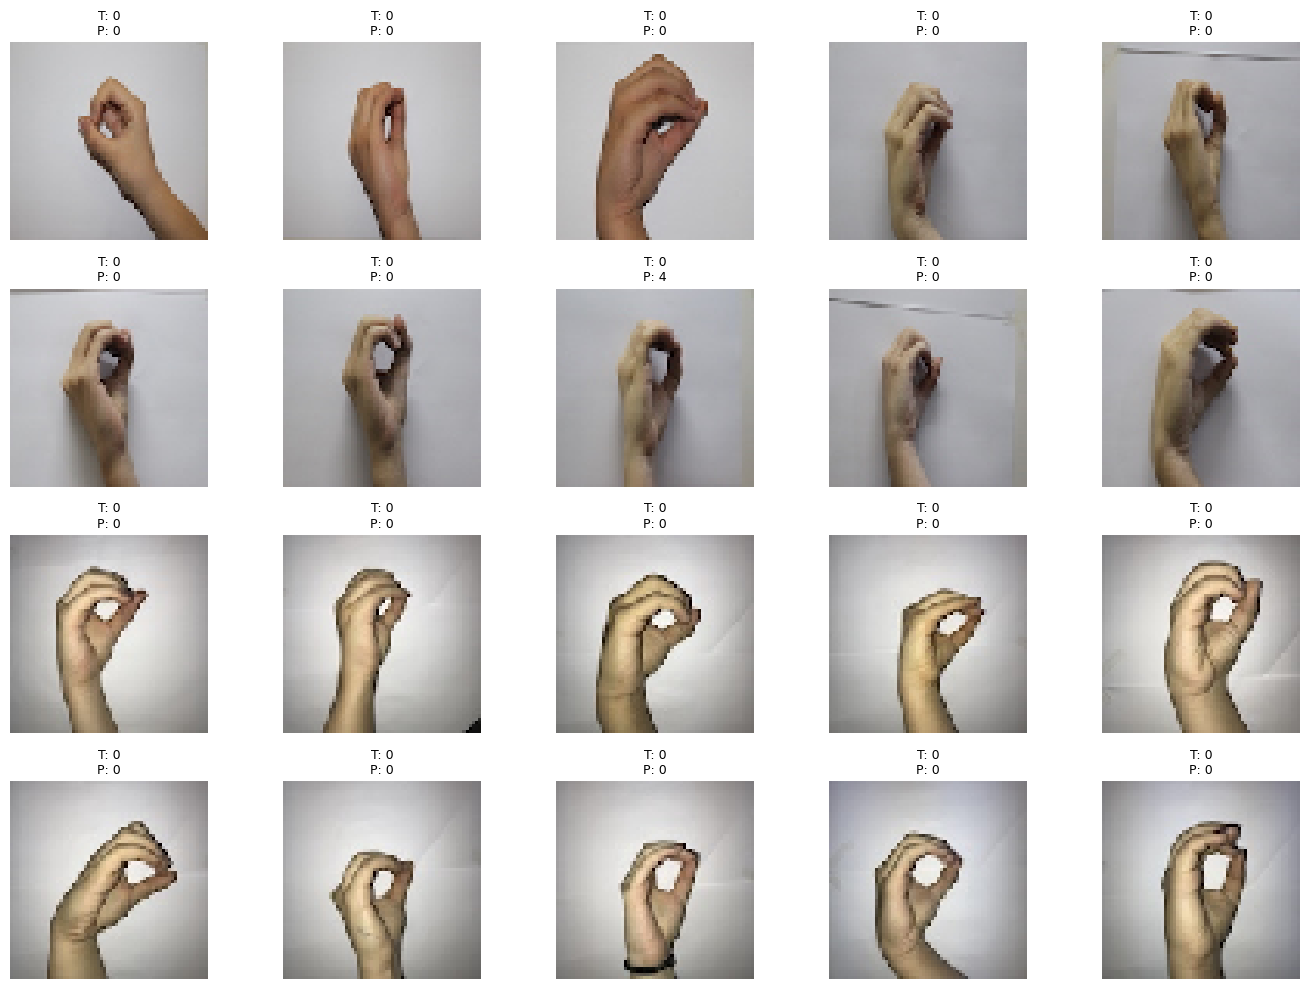

In [46]:
# STEP 10: 20 CORRECT PREDICTIONS (Training-set verification)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a NON-SHUFFLED training generator
verify_datagen = ImageDataGenerator(rescale=1./255)

verify_generator = verify_datagen.flow_from_directory(
    "small_dataset",
    target_size=(64, 64),
    batch_size=20,      # EXACTLY 20 images
    class_mode="categorical",
    shuffle=False       # VERY IMPORTANT
)

# Get one batch of 20 images
images, labels = next(verify_generator)

# Predict
predictions = model.predict(images)

true_classes = np.argmax(labels, axis=1)
pred_classes = np.argmax(predictions, axis=1)

# Label mapping
class_labels = {v: k for k, v in verify_generator.class_indices.items()}

# Check accuracy
accuracy = np.mean(true_classes == pred_classes) * 100
print(f"Verification Accuracy: {accuracy:.2f}%")

# Display all 50 predictions
plt.figure(figsize=(14, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(
        f"T: {class_labels[true_classes[i]]}\nP: {class_labels[pred_classes[i]]}",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.